# DISASTER TWEET IDENTIFICATION

In [1]:
# Data Manipulation libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

# NLP libraries
import string # Library for string operations
import nltk 
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re # Regex library
import demoji
from wordcloud import WordCloud # Word Cloud library

# ploting libraries
import matplotlib.pyplot as plt

# ML/AI libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout 
from tensorflow.python.keras.initializers import RandomNormal

2021-12-10 22:45:09.298827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-10 22:45:09.298846: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Loading Data

In [2]:
data = pd.read_csv("tweets_final_project_data.csv")

# Basic Info
print("Total DataSet: ", len(data))
print("Columns: ", list(data.columns))

X = data[["id", "keyword", "location", "text"]] # Features
y = data[["id","target"]] #Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("Training Data", len(y_train))
print("Testing Data", len(y_test))

data.head(3)

Total DataSet:  7613
Columns:  ['id', 'keyword', 'location', 'text', 'target']
Training Data 6090
Testing Data 1523


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


# Exploratory Data Analysis

## Analyzing Labels

In [3]:
Real_len = data[data['target'] == 1].shape[0]
Not_len = data[data['target'] == 0].shape[0]

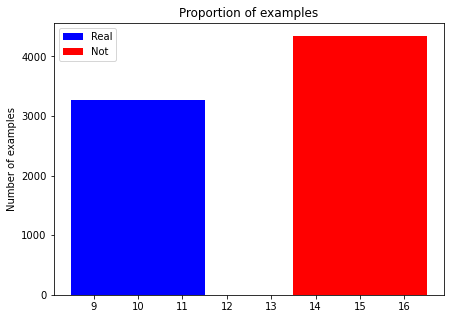

In [4]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

## Analyzing Features

### Sentence Length Analysis

In [5]:
def length(string):    
    return len(string)
data['length'] = data['text'].apply(length)
data.head

<bound method NDFrame.head of          id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  length  
0     Our Deeds are the Reason of this #earthquake M...       1      69  
1                Forest fire near La Ronge Sask. Canada       1      38  
2     All residents asked to 'shelter in place' are ...       1     133  
3     13,000 people receive #wildfires evacuation or...       1      65  
4     Just got sent this photo from Ruby #Alaska as ...       1      88  
...                                                 ...     ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1    

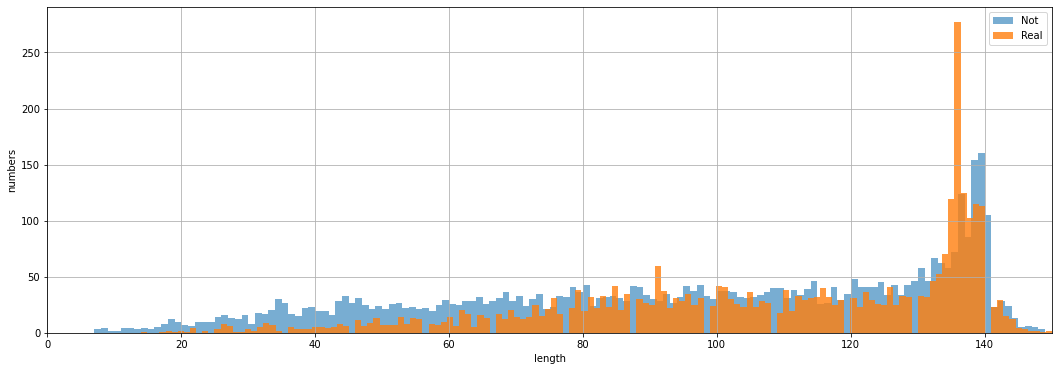

In [6]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(data[data['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

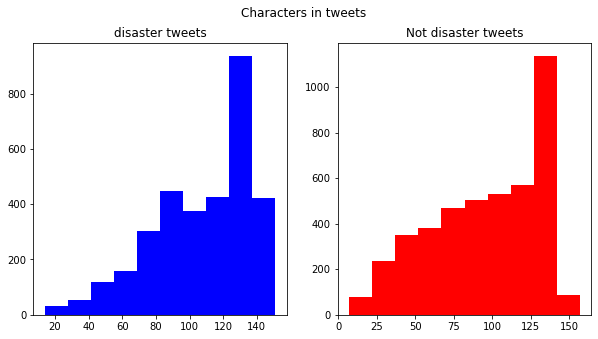

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data[data['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=data[data['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

# Data Cleaning

## Done to prepare data for analysis or modification by identifying data that is incorrect, incomplete, duplicate or badly formatted

### Possible text field may contain
### 1. URLs
### 2. Tags
### 3. Emoticons
### 4. HTML Tags
### 5. Stopwords
### 6. Useless Characters

#### 1. Removing URLs

In [8]:
def Remove_Url(string):
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\-)*\b', '', string)

In [9]:
print("Example of text with URL: \n", X_train['text'][3312], end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_Url)
print("Example of text without URL: \n", X_train['text'][3312])

Example of text with URL: 
 US govt refuses to evacuate 1000s of Americans from Yemen https://t.co/wQy3JOKuMH #yemen #usa #evacuation #abandoned

Example of text without URL: 
 US govt refuses to evacuate 1000s of Americans from Yemen  #yemen #usa #evacuation #abandoned


### 2. Handle Tags

In [10]:
def Handle_Tags(string):
    pattern = re.compile(r'[@|#][^\s]+')
    matches = pattern.findall(string)
    tags = [match[1:] for match in matches]
    # Removing tags from main string
    string = re.sub(pattern, '', string)
    # More weightage to tag by adding them 3 times
    return string + ' ' + ' '.join(tags) + ' '+ ' '.join(tags) + ' ' + ' '.join(tags)

In [11]:
print("Example of text without Handling Tags: \n", X_train['text'][3914],end = "\n\n")
X_train['text'] = X_train['text'].apply(Handle_Tags)
print("Example of text with Handling Tags: \n", X_train['text'][3914])

Example of text without Handling Tags: 
 Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_  

Example of text with Handling Tags: 
 Spot Flood Combo 53inch 300W Curved Cree LED Work Light Bar 4X4 Offroad Fog Lamp - Full reÛ_     


### 3. Handle Emoticons

In [12]:
def Handle_emoji(string):
    return demoji.replace_with_desc(string)

In [13]:
X_train['text'][39]

'Ablaze for you Lord :D   '

In [14]:
print("Example of text without Handled Emojis: \n", X_train['text'][39],end = "\n\n")
X_train['text'] = X_train['text'].apply(Handle_emoji)
print("Example of text with Handled Emoji: \n", X_train['text'][39])

Example of text without Handled Emojis: 
 Ablaze for you Lord :D   

Example of text with Handled Emoji: 
 Ablaze for you Lord :D   


#### All graphic emoticons have been text converted in the CSV so emoticons are already handled

### 4. Remove HTML Tags

In [15]:
def Remove_html(string):
    return re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', str(string))

In [16]:
X_train['text'] = X_train['text'].apply(Remove_html)

### 5. Remove Stopwords and Stemming

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
stemmer  = SnowballStemmer('english')

[nltk_data] Downloading package punkt to /home/nautilus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nautilus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
stopword = stopwords.words('english')
def Remove_StopAndStem(string):
    string_list = string.split()
    return ' '.join([stemmer.stem(i) for i in string_list if i not in stopword])

In [19]:
X_train['text'][209]

'The episode where Trunks annihilated Freiza is the cleanest shit ever. He showed that nigga no mercy.   '

In [20]:
print("Example of text before Removing Stopwords: \n", X_train['text'][209],end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_StopAndStem)
print("Example of text after Removing Stopwords and Stemming: \n", X_train['text'][209])

Example of text before Removing Stopwords: 
 The episode where Trunks annihilated Freiza is the cleanest shit ever. He showed that nigga no mercy.   

Example of text after Removing Stopwords and Stemming: 
 the episod trunk annihil freiza cleanest shit ever. he show nigga mercy.


### 6. Removing Useless Characters

In [21]:
def Remove_UC(string):
    thestring = re.sub(r'[^a-zA-Z\s]','', string)
    # remove word of length less than 2
    thestring = re.sub(r'\b\w{1,2}\b', '', thestring)
    #https://www.geeksforgeeks.org/python-remove-unwanted-spaces-from-string/
    return re.sub(' +', ' ', thestring) 

In [22]:
print("Example of text before Removing Useless Character: \n", X_train['text'][209],end = "\n\n")
X_train['text'] = X_train['text'].apply(Remove_UC)
print("Example of text after Removing Useless Character: \n", X_train['text'][209])

Example of text before Removing Useless Character: 
 the episod trunk annihil freiza cleanest shit ever. he show nigga mercy.

Example of text after Removing Useless Character: 
 the episod trunk annihil freiza cleanest shit ever show nigga mercy


In [23]:
def merging_details(data):
        #df = pd.DataFrame(columns=['id', 'Cleaned_data'])
        df_list = []
        
        
        for row in data.itertuples():
            df_dict = {}
            # Processing Keyword and location
            keyword = re.sub(r'[^a-zA-Z\s]','', str(row[2]))
            location = re.sub(r'[^a-zA-Z\s]','', str(row[3]))
            keyword = re.sub(r'\b\w{1,2}\b', '', keyword)
            location = re.sub(r'\b\w{1,2}\b', '', location)
            # Already processed data
            text = str(row[4])

            if keyword == 'nan':
                if location == 'nan':    
                    prs_data = text
                else:
                    prs_data = location + ' ' + text
            else:
                if location == 'nan':    
                    prs_data = keyword + ' ' + text
                else:
                    prs_data = keyword + ' ' + location + ' ' + text                
            
            prs_data = re.sub(' +', ' ', prs_data) 
            
            df_dict['Cleaned_data'] = prs_data
            
            df_list.append(df_dict)
            
                
        return pd.DataFrame(df_list)

In [24]:
X_train = merging_details(X_train)

In [25]:
X_train

,Cleaned_data
0,survived Reading romance novel surviv step pro...
1,collapsed great british bbakeb off back dorret...
2,deaths AsuncinPY TbingenGER breast milk origin...
3,sinkhole massiv sinkhol emerg brooklyn
4,sirens video playlist cher lloyd siren youtub ...
...,...
6085,deluge Fort Fizz Ohio vinc mcmahon billionaire...
6086,typhoon The Peach State think typhoon pass lol
6087,electrocuted not cool michael talk electrocut ...
6088,lightning SoDak check out lightn reshap rock a...


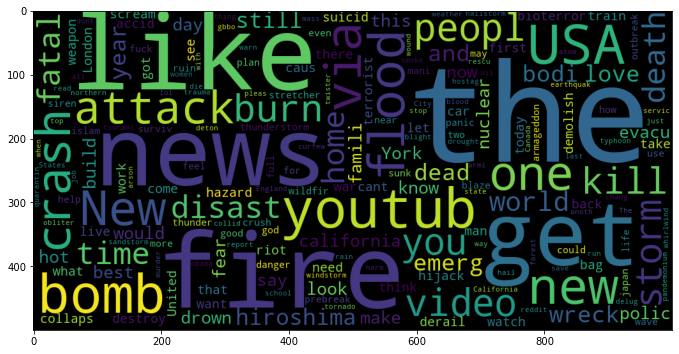

CPU times: user 976 ms, sys: 31.9 ms, total: 1.01 s
Wall time: 1.01 s


In [26]:
%%time
dict_of_words = {}
for row in  X_train.itertuples():
    for i in row[1].split():
        try:
            dict_of_words[i] += 1
        except:
            dict_of_words[i] = 1

#Initializing  WordCloud
wordcloud = WordCloud(background_color = 'black', width=1000, height=500).generate_from_frequencies(dict_of_words)
fig = plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.tight_layout(pad=1)
plt.show()

# Final Pre-Processing of Data

In [27]:
# Step 1. Remove Url
X_test['text'] = X_test['text'].apply(Remove_Url)
# Step 2. Handle Tags
X_test['text'] = X_test['text'].apply(Handle_Tags)
# Step 3. Handle emoji's
X_test['text'] = X_test['text'].apply(Handle_emoji)
# Step 4. Remove HTML Tags
X_test['text'] = X_test['text'].apply(Remove_html)
# Step 5. Remove Stopwords and Stemming
X_test['text'] = X_test['text'].apply(Remove_StopAndStem)
# Step 6. Removing Useless Characters
X_test['text'] = X_test['text'].apply(Remove_UC)
# Step7. Merging Other Details
X_test = merging_details(X_test)

In [28]:
X_test

,Cleaned_data
0,screamed Trumann Arkansas peopl scream right e...
1,hazardous Muntinlupa City Philippines also pls...
2,curfew BKIKUA her curfew start right privat cl...
3,desolation desol run till freediscountbks free...
4,rainstorm Fairfax tomorrow even commut receiv ...
...,...
1518,emergency Five down from the Coffeeshop came a...
1519,survivors Upstairs the second part focus survi...
1520,rainstorm North Vancouver yay feel wind gear r...
1521,duststorm sofa new mad max screenshot show off...


In [29]:
y_train = y_train['target']
y_test = y_test['target']

In [30]:
%%time
#smooth_idf=True by default so smoothing is done by defult.
#norm is l2 by default.
#subliner is used False by default.
vectorizer = TfidfVectorizer(min_df = 0.0005, 
                             max_features = 100000, 
                             tokenizer = lambda x: x.split(),
                             ngram_range = (1,4))


X_train = vectorizer.fit_transform(X_train['Cleaned_data'])
X_test = vectorizer.transform(X_test['Cleaned_data'])

CPU times: user 474 ms, sys: 28.1 ms, total: 503 ms
Wall time: 500 ms


In [31]:
#https://stackoverflow.com/questions/16505670/generating-a-dense-matrix-from-a-sparse-matrix-in-numpy-python
print("Training Points: ", len(X_train.toarray()),"| Training Features:" , len(X_train.toarray()[0]))
print("Testing Points: ", len(X_test.toarray()),"| Testing Features:" , len(X_test.toarray()[0]))
print()
print("Training Points: ", len(y_train))
print("Testing Points: ", len(y_test))

Training Points:  6090 | Training Features: 5564
Testing Points:  1523 | Testing Features: 5564

Training Points:  6090
Testing Points:  1523


# Machine Learning

## Logistic Regression

In [32]:
%%time

Model = LogisticRegression(C=1,penalty='l2')

Model.fit(X_train, y_train)

y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8102429415627052
Macro precision_recall_fscore_support
(0.8132014686228055, 0.7929781286848798, 0.7990131186901495, None)
Micro precision_recall_fscore_support
(0.8102429415627052, 0.8102429415627052, 0.8102429415627052, None)
Weighted precision_recall_fscore_support
(0.8115393026606234, 0.8102429415627052, 0.8070923523679049, None)
CPU times: user 76.4 ms, sys: 172 µs, total: 76.6 ms
Wall time: 74.6 ms


In [33]:
roc_auc_score(y_test, y_pred)

0.7929781286848797

# 

# Naive Bayes

## Gaussian Naive Bayes

In [34]:
%%time
Model = GaussianNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.7347340774786605
Macro precision_recall_fscore_support
(0.7802826274172081, 0.6907284874057026, 0.6909943752511049, None)
Micro precision_recall_fscore_support
(0.7347340774786605, 0.7347340774786605, 0.7347340774786605, None)
Weighted precision_recall_fscore_support
(0.7669826562401124, 0.7347340774786605, 0.7107650259961954, None)
CPU times: user 486 ms, sys: 293 ms, total: 779 ms
Wall time: 777 ms


In [35]:
roc_auc_score(y_test, y_pred)

0.6907284874057027

# Bernoulli Naive Bayes

In [36]:
%%time
Model = BernoulliNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.7918581746552856
Macro precision_recall_fscore_support
(0.8377647208014541, 0.7554181051016494, 0.764152229188904, None)
Micro precision_recall_fscore_support
(0.7918581746552856, 0.7918581746552856, 0.7918581746552856, None)
Weighted precision_recall_fscore_support
(0.8226184845570494, 0.7918581746552856, 0.7778990488743308, None)
CPU times: user 254 ms, sys: 124 ms, total: 379 ms
Wall time: 379 ms


In [37]:
roc_auc_score(y_test, y_pred)

0.7554181051016494

## Complement Naive Bayes

In [38]:
%%time
Model = ComplementNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8154957321076822
Macro precision_recall_fscore_support
(0.8196209886986275, 0.7979274105328957, 0.8043179961161995, None)
Micro precision_recall_fscore_support
(0.8154957321076822, 0.8154957321076822, 0.8154957321076822, None)
Weighted precision_recall_fscore_support
(0.8173428619245234, 0.8154957321076822, 0.8122713851870621, None)
CPU times: user 122 ms, sys: 91.8 ms, total: 214 ms
Wall time: 214 ms


In [39]:
roc_auc_score(y_test, y_pred)

0.7979274105328957

## Multinomial Naive Bayes

In [40]:
%%time
Model = MultinomialNB()
Model.fit(X_train.toarray(), y_train)
y_pred = Model.predict(X_test.toarray())

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8108995403808273
Macro precision_recall_fscore_support
(0.8276961023737424, 0.7859502194945233, 0.7947669848399774, None)
Micro precision_recall_fscore_support
(0.8108995403808273, 0.8108995403808273, 0.8108995403808273, None)
Weighted precision_recall_fscore_support
(0.8203846577415324, 0.8108995403808273, 0.8045523054139356, None)
CPU times: user 101 ms, sys: 76.5 ms, total: 178 ms
Wall time: 176 ms


# 

# Support Vector Machines (SVM)

### RBF Kernel SVM

In [41]:
%%time
Model = svm.SVC(kernel='rbf') #rbf by default svm.SVC()
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8095863427445831
Macro precision_recall_fscore_support
(0.813893003548176, 0.7912671013936836, 0.7977116088538442, None)
Micro precision_recall_fscore_support
(0.8095863427445831, 0.8095863427445831, 0.8095863427445831, None)
Weighted precision_recall_fscore_support
(0.81156434979425, 0.8095863427445831, 0.8060464491728181, None)
CPU times: user 3.51 s, sys: 50.8 ms, total: 3.56 s
Wall time: 3.56 s


In [42]:
roc_auc_score(y_test, y_pred)

0.7912671013936837

## Linear SVC

In [43]:
%%time
Model = svm.SVC(kernel='linear') 
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.8036769533814839
Macro precision_recall_fscore_support
(0.8035900629481267, 0.7882863444572306, 0.7932515044958945, None)
Micro precision_recall_fscore_support
(0.8036769533814839, 0.8036769533814839, 0.8036769533814839, None)
Weighted precision_recall_fscore_support
(0.8036430150004549, 0.8036769533814839, 0.8011468005817649, None)
CPU times: user 2.57 s, sys: 31.5 ms, total: 2.61 s
Wall time: 2.6 s


## Random Forest Classifier

In [44]:
%%time
Model = RandomForestClassifier(random_state=0)
Model.fit(X_train, y_train)
y_pred = Model.predict(X_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print("Macro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))
print("Micro precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print("Weighted precision_recall_fscore_support")
print(precision_recall_fscore_support(y_test, y_pred, average='weighted'))

Acuracy 0.793827971109652
Macro precision_recall_fscore_support
(0.7934839346872559, 0.7775691159129978, 0.7825393793881188, None)
Micro precision_recall_fscore_support
(0.793827971109652, 0.793827971109652, 0.793827971109652, None)
Weighted precision_recall_fscore_support
(0.7936887747640388, 0.793827971109652, 0.7909651582234996, None)
CPU times: user 3.88 s, sys: 19.3 ms, total: 3.9 s
Wall time: 3.9 s
